In [51]:
import pandas as pd
import math, json, sys
import numpy as np
import seaborn as sns
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib import style

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
style.use('ggplot')

In [76]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# we need a schema file
schema = json.loads(open('schema2.json', 'r').read())

#train = pd.read_csv('../kaggle-house-prices-advanced-regression-techniques/categorical_to_numerical/newtrain.csv')
#test = pd.read_csv('../kaggle-house-prices-advanced-regression-techniques/categorical_to_numerical/newtest.csv')
#schema = json.loads(open('../kaggle-house-prices-advanced-regression-techniques/categorical_to_numerical/newschema.json', 'r').read())

In [77]:
target = schema['target']
labels = train[target]
features = set(train.columns) - set([target,schema['id']])
print features
train.drop([target],axis=1,inplace=True)
all_data = pd.concat((train, test)).reset_index(drop=True)

set(['3SsnPorch', 'MasVnrType', 'LotConfig', 'LandSlope', 'GarageQual', 'Exterior1st', 'GarageFinish', '2ndFlrSF', 'HalfBath', 'OverallQual', 'OverallCond', 'LotArea', 'Electrical', 'BsmtQual', 'HouseStyle', 'GrLivArea', 'YearRemodAdd', 'MasVnrArea', 'Foundation', '1stFlrSF', 'BsmtFullBath', 'BsmtCond', 'HeatingQC', 'LotFrontage', 'MiscVal', 'CentralAir', 'BsmtExposure', 'Utilities', 'KitchenAbvGr', 'WoodDeckSF', 'LotShape', 'BsmtHalfBath', 'TotalBsmtSF', 'Condition1', 'Condition2', 'TotRmsAbvGrd', 'MiscFeature', 'YrSold', 'PavedDrive', 'OpenPorchSF', 'LowQualFinSF', 'BsmtUnfSF', 'GarageYrBlt', 'BldgType', 'FullBath', 'SaleType', 'MSZoning', 'Exterior2nd', 'Heating', 'MSSubClass', 'GarageCars', 'YearBuilt', 'KitchenQual', 'BsmtFinType2', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinSF2', 'GarageType', 'LandContour', 'PoolArea', 'Neighborhood', 'ScreenPorch', 'Fence', 'MoSold', 'SaleCondition', 'ExterQual', 'Functional', 'Alley', 'RoofStyle', 'Street', 'Fireplaces', 'GarageArea', 'ExterCond', 

## Check train+test missing data

Number of features with missing data: 34


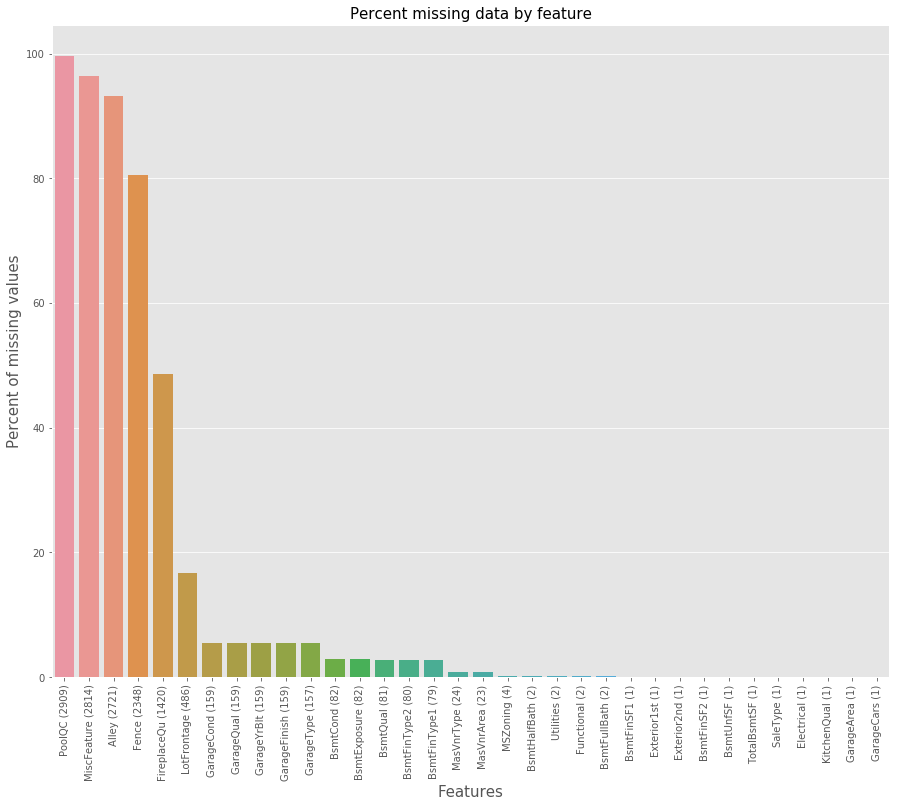

In [42]:
# Check missing data
all_data_na = all_data.isnull().sum(axis=0).sort_values(ascending=False)
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index)

nmissing = all_data_na.shape[0]
print 'Number of features with missing data:',nmissing

if nmissing > 0:
    all_data_na_pct = (all_data_na / all_data.shape[0]) * 100

    annotations = ["{} ({})".format(a, b) for a, b in zip(all_data_na.index, all_data_na.values)]

    f, ax = plt.subplots(figsize=(15, 12))
    sns.barplot(x=annotations, y=all_data_na_pct)

    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)

## Check train columns with unique value

In [43]:
for c in train.columns:
    if train[c].nunique() <= 1:
        print 'Column',c,'has only one value:',train[c].any()

## Check target variable

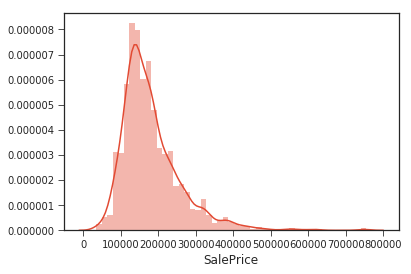

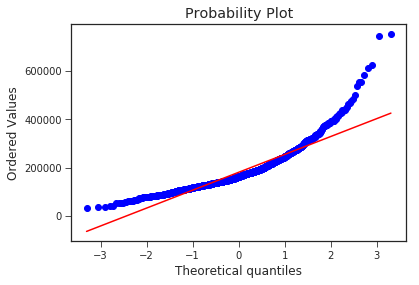

In [105]:
sns.distplot(labels)

fig = plt.figure()
res = stats.probplot(labels, plot=plt)
plt.show()

## Check linearity of train NUMERIC features

['3SsnPorch', '2ndFlrSF', 'HalfBath', 'LotArea', 'GrLivArea', 'YearRemodAdd', 'MasVnrArea', '1stFlrSF', 'BsmtFullBath', 'LotFrontage', 'MiscVal', 'KitchenAbvGr', 'WoodDeckSF', 'BsmtHalfBath', 'TotalBsmtSF', 'TotRmsAbvGrd', 'YrSold', 'OpenPorchSF', 'LowQualFinSF', 'BsmtUnfSF', 'GarageYrBlt', 'FullBath', 'GarageCars', 'YearBuilt', 'BsmtFinSF1', 'BsmtFinSF2', 'PoolArea', 'ScreenPorch', 'MoSold', 'Fireplaces', 'GarageArea', 'EnclosedPorch', 'BedroomAbvGr']


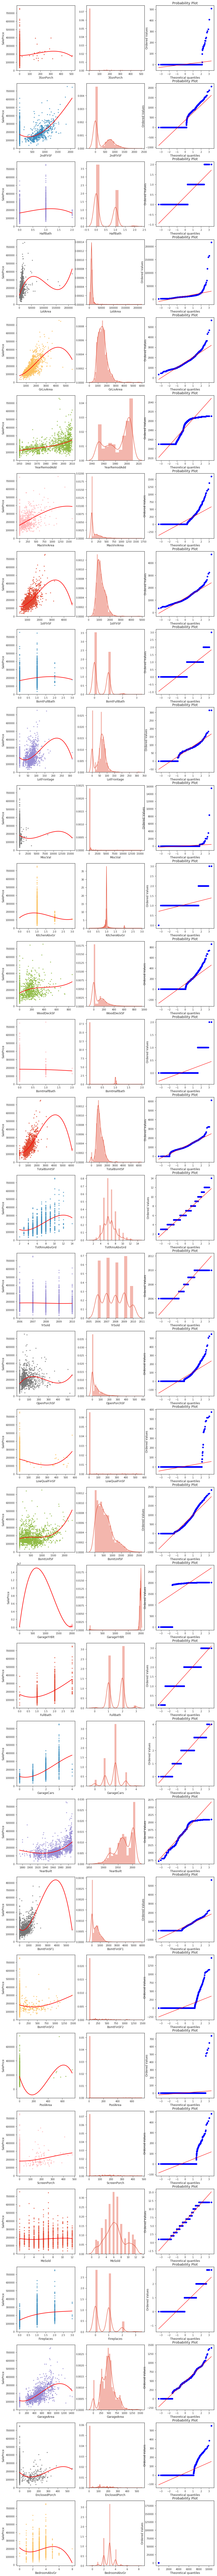

In [140]:
numeric_features = [c for c in features if schema['columns'][c]['type'] == 'NUMERIC']
print numeric_features

sns.set_style('ticks')
fig, ax = plt.subplots(len(numeric_features),3,figsize=(15, 200))
for i,c in enumerate(numeric_features):
    values = train[c].fillna(0)
    sns.regplot(x=values, y=labels, ax=ax[i,0], scatter_kws={"s": 10},
                line_kws={'color':'red'}, order=3, ci=None, truncate=True)
    sns.distplot(values,ax=ax[i,1])
    res = stats.probplot(values, plot=ax[i,2])
